In [58]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

In [59]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [60]:
import os
import sys

nb_dir_1 = os.path.split(os.getcwd())[0]
current_path = os.getcwd()
parent = os.path.dirname(current_path)
nb_dir_2 = os.path.split(parent)[0]

if nb_dir_1 not in sys.path:
    sys.path.append(nb_dir_1)

if nb_dir_2 not in sys.path:
    sys.path.append(nb_dir_2)

In [61]:
import numpy as np
import pandas as pd
import torch
from core.models import LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import scipy.stats
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from core.data_preparation import DataPreparation
from core.curve_fit import fit_polynomial_curve_to_data_and_visualize

In [62]:
# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

In [63]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


In [64]:
filepath = "../Data/IBM_2010-2022.csv"
data = pd.read_csv(filepath, usecols=[0,4], names=['date', 'close'], header=0)
data = data.sort_values('date')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,close
0,2010-01-04,126.625237
1,2010-01-05,125.095604
2,2010-01-06,124.282982
3,2010-01-07,123.852776
4,2010-01-08,125.095604


In [65]:
data.tail()

,date,close
3036,2022-01-25,136.100006
3037,2022-01-26,134.259995
3038,2022-01-27,132.520004
3039,2022-01-28,134.500000
3040,2022-01-31,133.570007


In [66]:
data['close'].isnull().values.any()

False

In [67]:
# data[data['date'] == '2013-01-02'].index

In [68]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='closing price'))

fig.update_layout(
    title="IBM stock closing price from 2010 to February 2022",
    xaxis_title="Date",
    yaxis_title="Closing price in USD",    
    font=dict(
        family="Ariale",
        size=16       
    )
)

In [69]:
TsAD = importr('otsad')
TSdist = importr('TSdist')

In [70]:
train_len = 0.8*len(data)

In [71]:
res = TsAD.OcpTsSdEwma(data['close'].values, train_len, 0.01, 3, 20)

In [72]:
df = pd.DataFrame(res)

In [73]:
df.head()

,is.anomaly,lcl,ucl
0,0.0,126.625237,126.625237
1,0.0,125.095604,125.095604
2,0.0,124.282982,124.282982
3,0.0,123.852776,123.852776
4,0.0,125.095604,125.095604


In [74]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['close'], mode='lines', name='close price'))
fig.add_trace(go.Scatter(x=df.index, y=df['lcl'], mode='lines', name='lower control limit'))
fig.add_trace(go.Scatter(x=df.index, y=df['ucl'], mode='lines', name='upper control limit'))

In [75]:
anomaly_indices = df[df['is.anomaly'] == 1.0].index

In [76]:
rows = data.iloc[anomaly_indices, :]

In [77]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='closing price'))
fig.add_trace(go.Scatter(x=rows['date'], y=rows['close'], mode='markers', name='anomalies'))

In [78]:
window_size = 20
prep = DataPreparation()
scaler = MinMaxScaler(feature_range=(-1, 1))

In [79]:
train_set, test_set = prep.splitData(data['close'].values)

In [80]:
scaler, x_train, x_test, y_train_lstm, y_test_lstm = prep.normalize_and_prepare_data(data['close'].values, scaler)

x_train.shape =  (2413, 20, 1)
y_train.shape =  (2413, 1)
x_test.shape =  (588, 20, 1)
y_test.shape =  (588, 1)


In [81]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step() 

In [82]:
torch.save(model, 'lstm_ibm.pt')

In [83]:
actual_test_len = len(test_set) - window_size

In [84]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_test_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

preds = y_test_pred[:, 0]
gt = y_test[:, 0]

Test Score: 0.02 MAPE
R-squared value is 0.9028784694941713
RMSE:  3.1574076427444298


In [85]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-actual_test_len:], y=y_test[:,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y=df['lcl'][-actual_test_len:], mode='lines', name='lower control limit'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y=df['ucl'][-actual_test_len:], mode='lines', name='upper control limit'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y= y_test_pred[:,0], mode='lines', name='predicted close price'))


#### Find distance between forecast distributions and actual test values using different distance measures from R

### Dynamic Time Warping

In [86]:
dtw_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  dtw = TSdist.DTWDistance(X1, X2)
  dtw_dist.append(dtw.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "DTW distance" : dtw_dist

    }

df1 = pd.DataFrame(finalResult)

In [87]:
pdc_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  pdc = TSdist.PDCDistance(X1, X2)
  pdc_dist.append(pdc.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "PDC distance" : pdc_dist

    }

df2 = pd.DataFrame(finalResult)

In [88]:
cort_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  # print(X2.shape)

  ## convert to np.array
  X1 = rpy2.robjects.FloatVector(X1)
  X2 = rpy2.robjects.FloatVector(X2)

  # print(type(X1))

  cort = TSdist.CortDistance(X1, X2, deltamethod="DTW")
  cort_dist.append(cort.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Temporal Correlation distance" : cort_dist

    }

df3 = pd.DataFrame(finalResult)

In [89]:
df3

,range,Temporal Correlation distance
0,0 : 100,111.715959
1,100 : 200,247.332548
2,200 : 300,130.749175
3,300 : 400,145.082273
4,400 : 500,105.931844


In [90]:
fourier_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1 = rpy2.robjects.FloatVector(X1)
  X2 = rpy2.robjects.FloatVector(X2)

  fourier = TSdist.FourierDistance(X1, X2)
  fourier_dist.append(fourier.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Fourier distance" : fourier_dist

    }

df4 = pd.DataFrame(finalResult)

In [91]:
df4

,range,Fourier distance
0,0 : 100,195.636263
1,100 : 200,377.703361
2,200 : 300,194.572626
3,300 : 400,170.376980
4,400 : 500,130.449052


#### KL divergence

In [92]:
def computeKLD(X1, X2, bins=5):

    # values_1, edges_1 = np.histogram(X1,bins=bins,density=True)
    # values_2, edges_2 = np.histogram(X2,bins=bins,density=True)

    values_1, edges_1 = np.histogram(X1,bins=bins)
    values_2, edges_2 = np.histogram(X2,bins=bins)
   
    #Consider only first std. deviation of original series i.e. P(x).    
    P = values_1
    Q = values_2
    delta_x = 2/bins
    res =  np.sum( P * np.log2( P/Q )) * delta_x
    return res

In [93]:
KLD = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    kld_res = computeKLD(X1, X2)

    KLD.append(kld_res)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "KL divergence" : KLD

}

df5 = pd.DataFrame(finalResult)

#### Jensen Shannon Divergence

In [94]:
def jsd(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    if len(p)>len(q):
        p = np.random.choice(p,len(q)) # random.choice make same length to p/q
    elif len(q)>len(p):
        q = np.random.choice(q,len(p))
    ## convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    ## normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    
    return scipy.stats.entropy(p,m, base=base)/2. +  scipy.stats.entropy(q, m, base=base)/2

In [95]:
JSD = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    jsd_res = jsd(X1, X2)

    JSD.append(jsd_res)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "JS divergence" : JSD

}

df6 = pd.DataFrame(finalResult)

In [96]:
result = pd.concat([df1, df2['PDC distance'], df3['Temporal Correlation distance'],
 df4['Fourier distance'], df5['KL divergence'], df6['JS divergence']], axis=1)
result

,range,DTW distance,PDC distance,Temporal Correlation distance,Fourier distance,KL divergence,JS divergence
0,0 : 100,117.786736,0.730381,111.715959,195.636263,2.070799,0.000052
1,100 : 200,243.826149,0.979564,247.332548,377.703361,19.063736,0.000245
2,200 : 300,123.902901,1.392135,130.749175,194.572626,24.109799,0.000066
3,300 : 400,125.437599,0.754779,145.082273,170.376980,1.730981,0.000048
4,400 : 500,91.075821,0.885610,105.931844,130.449052,0.300636,0.000021


In [97]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-len(x_test):], y=data['close'][-len(x_test):], mode='lines', name='closing price'))

In [98]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[:100], y=y_test[:100,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[:100], y= y_test_pred[:100,0], mode='lines', name='predicted close price'))

In [99]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[100:200], y=y_test[100:200,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[100:200], y= y_test_pred[100:200,0], mode='lines', name='predicted close price'))

In [100]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[200:300], y=y_test[200:300,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[200:300], y= y_test_pred[200:300,0], mode='lines', name='predicted close price'))

In [101]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[300:400], y=y_test[300:400,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[300:400], y= y_test_pred[300:400,0], mode='lines', name='predicted close price'))

In [102]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[400:500], y=y_test[400:500,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[400:500], y= y_test_pred[400:500,0], mode='lines', name='predicted close price'))

#### Measure how accuracy of model changes with shift in test set

In [103]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*100} : {(i+1)*100}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df = pd.DataFrame(accuracy)

In [104]:
acc_df

,range,RMSE,MAPE,R2-score
0,0 : 100,2.757076,1.361479,0.795814
1,100 : 200,5.186742,3.458376,0.581938
2,200 : 300,2.707843,1.703483,0.650047
3,300 : 400,2.404439,1.336910,0.871747
4,400 : 500,1.798920,0.956758,0.758863


In [105]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(8):
    
    X1, X2 = gt[i*70 : (i+1)*70], preds[i*70 : (i+1)*70]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*70} : {(i+1)*70}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df2 = pd.DataFrame(accuracy)

In [106]:
acc_df2

,range,RMSE,MAPE,R2-score
0,0 : 70,1.923044,1.030068,0.507607
1,70 : 140,5.945067,3.918181,0.874880
2,140 : 210,3.314466,2.185464,0.282922
3,210 : 280,2.909829,1.802351,0.641548
4,280 : 350,2.395474,1.345931,0.571176
5,350 : 420,2.105552,1.158021,0.930251
6,420 : 490,1.880630,0.986748,0.699205
7,490 : 560,3.046411,1.676575,0.811402


In [107]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(11):
    
    X1, X2 = gt[i*50 : (i+1)*50], preds[i*50 : (i+1)*50]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*50} : {(i+1)*50}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df3 = pd.DataFrame(accuracy)

In [108]:
acc_df3

,range,RMSE,MAPE,R2-score
0,0 : 50,2.196182,1.220008,0.506304
1,50 : 100,3.221758,1.502949,0.801906
2,100 : 150,6.462932,4.715581,0.588386
3,150 : 200,3.469162,2.201172,0.318936
4,200 : 250,1.929970,1.379021,0.267602
5,250 : 300,3.307573,2.027945,0.612694
6,300 : 350,2.500774,1.348117,0.431954
7,350 : 400,2.304081,1.325703,0.890894
8,400 : 450,2.074629,1.034901,0.481348
9,450 : 500,1.472460,0.878615,0.653537


#### ECDF distance measures between actual values and forecasts

In [109]:
wasserstein_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = Wasserstein_Dist(X1, X2)

    wasserstein_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "Wasserstein distance" : wasserstein_distance

}

df7 = pd.DataFrame(finalResult)

In [110]:
KS_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = Kolmogorov_Smirnov_Dist(X1, X2)

    KS_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "Kolmogorov Smirnov distance" : KS_distance

}

df8 = pd.DataFrame(finalResult)

In [111]:
DTS_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = DTS_Dist(X1, X2)

    DTS_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "DTS distance" : DTS_distance

}

df9 = pd.DataFrame(finalResult)

In [112]:
result = pd.concat([df7, df8['Kolmogorov Smirnov distance'], df9['DTS distance']], axis=1)
result

,range,Wasserstein distance,Kolmogorov Smirnov distance,DTS distance
0,0 : 100,0.513765,0.21,0.125334
1,100 : 200,1.323540,0.14,0.429029
2,200 : 300,0.594897,0.09,0.166416
3,300 : 400,0.789582,0.12,0.193415
4,400 : 500,0.526729,0.11,0.118486


#### ECDF distance measures between train set and test set

In [113]:
dtw_dist = []
test_set_range = []

for i in range(8):

  X1, X2 = train_set, gt[i*70 : (i+1)*70]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  dtw = TSdist.DTWDistance(X1, X2)
  dtw_dist.append(np.round(dtw.item(), 2))
  test_set_range.append(f'{i*70} : {(i+1)*70}')

finalResult_dtw = { "range" : test_set_range,    
    "DTW distance" : dtw_dist,

    }

df_dtw = pd.DataFrame(finalResult_dtw)

In [114]:
df_dtw

,range,DTW distance
0,0 : 70,55929.70
1,70 : 140,38379.56
2,140 : 210,67571.55
3,210 : 280,76008.36
4,280 : 350,75677.26
5,350 : 420,47361.38
6,420 : 490,46041.75
7,490 : 560,52278.05


In [115]:
def get_statistical_dist_measures(X_train, X_test):   

    CVM_distance = Cramer_Von_Mises_Dist(X_train, X_test)
    Anderson_Darling_distance = Anderson_Darling_Dist(X_train, X_test)
    Kolmogorov_Smirnov_distance = Kolmogorov_Smirnov_Dist(X_train, X_test)
    Kuiper_distance = Kuiper_Dist(X_train, X_test)
    Wasserstein_distance = Wasserstein_Dist(X_train, X_test)
    DTS_distance = DTS_Dist(X_train, X_test)   
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [116]:
test_set_range = []
finalResult = []

for i in range(5):
    
    X1, X2 = train_set, gt[i*100 : (i+1)*100]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult.append(distances)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



In [117]:
test_set_range = []
finalResult2 = []

for i in range(8):
    
    X1, X2 = train_set, gt[i*70 : (i+1)*70]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult2.append(distances)
    test_set_range.append(f'{i*70} : {(i+1)*70}')



In [118]:
df = pd.DataFrame(finalResult)
# df.insert(0, 'Test set range', test_set_range)
frames = [acc_df[['RMSE',  'R2-score', 'MAPE']], df]
df = pd.concat(frames, axis=1)
df

#As distance between train and test increases, model's performance decreases. We should analyse this point here.
# Only DTS_dist and Wasserstein_dist are positively correlated to model's accuracy.

,RMSE,R2-score,MAPE,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,2.757076,0.795814,1.361479,31.691825,696.346654,1.157570,0.608323,0.721763,24.633876
1,5.186742,0.581938,3.458376,53.674373,1020.157111,2.691866,0.848064,0.848064,41.163155
2,2.707843,0.650047,1.703483,52.741637,1019.110551,2.225913,0.911085,0.911085,39.216023
3,2.404439,0.871747,1.336910,44.568967,906.019236,1.690677,0.738746,0.747789,33.286470
4,1.798920,0.758863,0.956758,28.229630,628.984258,1.034408,0.636252,0.758734,22.180258


In [119]:
res = pd.concat([acc_df[['RMSE',  'R2-score', 'MAPE']], df[['DTS_dist', 'Wasserstein_dist', 'CVM_dist']]], axis=1)
res = res.style.set_caption("Correlation between accuracy of prediction models with different distance measures").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('text-align', 'center'),
        ('color', 'black') ,       
        ('font-size', '18px'),
        ('font-family', 'Arial')
    ]
}])
# res = res.style.set_caption('Correlation between accuracy of prediction models with different distance measures')
res

,RMSE,R2-score,MAPE,DTS_dist,Wasserstein_dist,CVM_dist
0,2.757076,0.795814,1.361479,1.157570,24.633876,696.346654
1,5.186742,0.581938,3.458376,2.691866,41.163155,1020.157111
2,2.707843,0.650047,1.703483,2.225913,39.216023,1019.110551
3,2.404439,0.871747,1.336910,1.690677,33.286470,906.019236
4,1.798920,0.758863,0.956758,1.034408,22.180258,628.984258


In [120]:
df1 = pd.DataFrame(finalResult2)
df1.insert(0, 'Test set range', test_set_range)
df1

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,35.306030,769.071106,1.292939,0.772709,0.886149,27.388514
1,70 : 140,40.672690,774.850907,2.479631,0.545417,0.545417,32.727005
2,140 : 210,51.994639,996.655581,2.093510,0.870630,0.875562,38.230077
3,210 : 280,53.150188,1007.515020,2.355314,0.915020,0.915020,39.495646
4,280 : 350,51.402900,991.520334,2.065124,0.889948,0.893236,37.978478
5,350 : 420,33.606698,722.109230,1.256371,0.693071,0.702114,26.022515
6,420 : 490,28.252191,624.117445,1.055108,0.636252,0.790793,22.445493
7,490 : 560,39.701289,827.634490,1.485312,0.743115,0.759967,30.056246


In [121]:
frames = [df1[['Test set range']], acc_df2[['RMSE',  'R2-score', 'MAPE']], df1.iloc[:, 1:]]
df1 = pd.concat(frames, axis=1)
df1


,Test set range,RMSE,R2-score,MAPE,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,1.923044,0.507607,1.030068,35.306030,769.071106,1.292939,0.772709,0.886149,27.388514
1,70 : 140,5.945067,0.874880,3.918181,40.672690,774.850907,2.479631,0.545417,0.545417,32.727005
2,140 : 210,3.314466,0.282922,2.185464,51.994639,996.655581,2.093510,0.870630,0.875562,38.230077
3,210 : 280,2.909829,0.641548,1.802351,53.150188,1007.515020,2.355314,0.915020,0.915020,39.495646
4,280 : 350,2.395474,0.571176,1.345931,51.402900,991.520334,2.065124,0.889948,0.893236,37.978478
5,350 : 420,2.105552,0.930251,1.158021,33.606698,722.109230,1.256371,0.693071,0.702114,26.022515
6,420 : 490,1.880630,0.699205,0.986748,28.252191,624.117445,1.055108,0.636252,0.790793,22.445493
7,490 : 560,3.046411,0.811402,1.676575,39.701289,827.634490,1.485312,0.743115,0.759967,30.056246


In [122]:
res = pd.concat([acc_df2[['RMSE',  'R2-score', 'MAPE']], df1[['DTS_dist', 'Wasserstein_dist', 'CVM_dist']], df_dtw[['DTW distance']]], axis=1)
res = res.style.set_caption("Correlation between accuracy of prediction models with different distance measures").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('text-align', 'center'),
        ('color', 'black') ,       
        ('font-size', '18px'),
        ('font-family', 'Arial')
    ]
}])
# res = res.style.set_caption('Correlation between accuracy of prediction models with different distance measures')
res

,RMSE,R2-score,MAPE,DTS_dist,Wasserstein_dist,CVM_dist,DTW distance
0,1.923044,0.507607,1.030068,1.292939,27.388514,769.071106,55929.700000
1,5.945067,0.874880,3.918181,2.479631,32.727005,774.850907,38379.560000
2,3.314466,0.282922,2.185464,2.093510,38.230077,996.655581,67571.550000
3,2.909829,0.641548,1.802351,2.355314,39.495646,1007.515020,76008.360000
4,2.395474,0.571176,1.345931,2.065124,37.978478,991.520334,75677.260000
5,2.105552,0.930251,1.158021,1.256371,26.022515,722.109230,47361.380000
6,1.880630,0.699205,0.986748,1.055108,22.445493,624.117445,46041.750000
7,3.046411,0.811402,1.676575,1.485312,30.056246,827.634490,52278.050000


In [123]:
test_set_range = []
finalResult3 = []

for i in range(11):
    
    X1, X2 = train_set, gt[i*50 : (i+1)*50]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult3.append(distances)
    test_set_range.append(f'{i*50} : {(i+1)*50}')



In [124]:
df3 = pd.DataFrame(finalResult3)
df3.insert(0, 'Test set range', test_set_range)
df3.head()

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 50,34.705778,753.126034,1.280187,0.772709,0.886149,26.983604
1,50 : 100,28.090141,610.488319,1.066811,0.545417,0.666256,22.374699
2,100 : 150,54.804420,997.532520,3.421264,0.848064,0.848064,43.348528
3,150 : 200,53.172328,996.230884,2.224122,0.864916,0.869848,39.001751
4,200 : 250,50.521523,979.295791,1.977999,0.921085,0.929305,37.199265


In [125]:
y_values = 100 - acc_df2['MAPE']
# y_values

In [126]:
fig = px.scatter(x=df1['Wasserstein_dist'], y=y_values, labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (100-MAPE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [127]:
fig = px.scatter(x=df1['Wasserstein_dist'], y=df1['RMSE'], labels=dict(x="Dissimilarity (Wasserstein distance)", y="Performance (RMSE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [153]:
x = np.array(df1['Wasserstein_dist'].values)
y = np.array(df1['RMSE'].values)
z = np.polyfit(x, y, 2)
z

array([ -0.02332453,   1.54460419, -21.7661481 ])

In [154]:
p = np.poly1d(z)

In [155]:
xp = np.linspace(20, 40, 100)

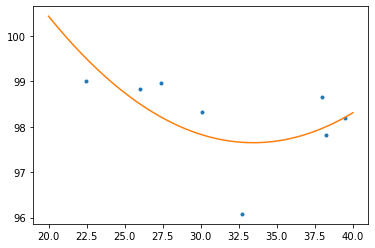

In [150]:
import matplotlib.pyplot as plt
# xp = x
_ = plt.plot(x, y, '.', xp, p(xp))

plt.show()

In [156]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df1['Wasserstein_dist'], y=df1['RMSE'], mode='markers', marker_symbol='square', marker = dict(size=10, color='red'), name='Data'))
fig.add_trace(go.Scatter(x=xp, y=p(xp), mode='lines', name='Fitted Curve', marker=dict(color='Blue')))
fig.update_layout(
    title="An illustration of fitting a curve to statistical mapping of dissimilarity and performance",
    xaxis_title="Dissimilarity (Wasserstein distance)",
    yaxis_title="Performance (RMSE)",  
    font=dict(
        family="Arial",
        size=16,
        color="Black"
    )
)
fig.show()

In [157]:
ys = 100 - acc_df2['MAPE']

In [158]:
x = np.array(df1['Wasserstein_dist'].values)
y = np.array(ys)
z = np.polyfit(x, y, 2)

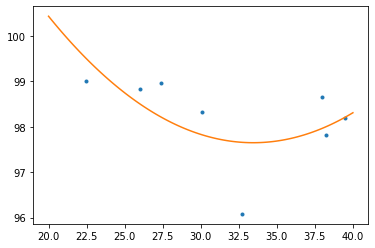

In [159]:
p = np.poly1d(z)
xp = np.linspace(20, 40, 100)
_ = plt.plot(x, y, '.', xp, p(xp))

plt.show()

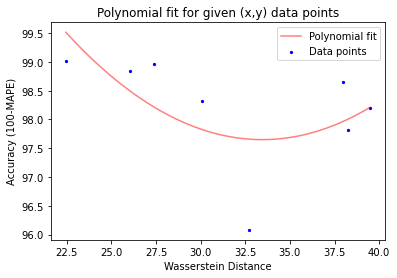

In [136]:
fit_polynomial_curve_to_data_and_visualize(df1['Wasserstein_dist'].values, ys, xlabel='Wasserstein Distance', ylabel='Accuracy (100-MAPE)')

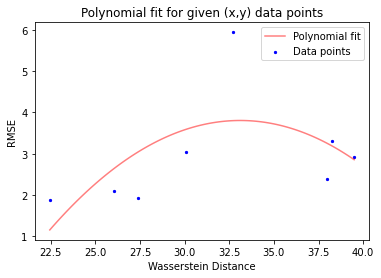

In [137]:
fit_polynomial_curve_to_data_and_visualize(df1['Wasserstein_dist'].values, df1['RMSE'].values, xlabel='Wasserstein Distance', ylabel='RMSE')

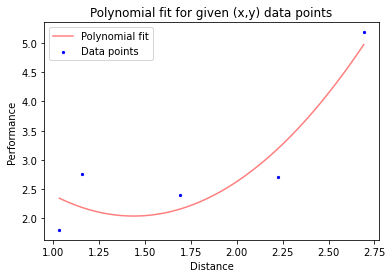

In [138]:
fit_polynomial_curve_to_data_and_visualize(df['DTS_dist'].values, df['RMSE'].values)

#### Curve fitting using Scipy's curve_fit() function

In [139]:
from scipy.optimize import curve_fit
import math

In [140]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

In [141]:
y_values = 100 - acc_df2['MAPE']
# y_values

In [142]:
xs = df1['Wasserstein_dist'].values
ys = y_values.tolist()

In [143]:
p0 = (4, .1, 0.5) # start with values near those we expect
# params, cv =  curve_fit(monoExp, xs, ys, p0)
# m, t, b = params

In [144]:
# # plot the results
# plt.plot(xs, ys, '.', label="data")
# plt.plot(xs, monoExp(xs, m, t, b), '--', label="fitted")

In [145]:
fig = px.scatter(x=df['Wasserstein_dist'], y=df['R2-score'])
fig.update_traces(marker_size=10)
fig.show()

#### Timseries based similarity measures between train and test

In [146]:
def get_timeseries_distance_measures(X1, X2):
    
    DTW_distance = TSdist.DTWDistance(X1, X2)    
    Jensen_Shannon_distance = jsd(X1, X2)
    KL_Divergence = computeKLD(X1, X2, 7)

    return {'DTW_distance': "{:.2f}".format(DTW_distance.item()),            
            'Jensen_Shannon_distance':Jensen_Shannon_distance,
            'KL_Divergence': KL_Divergence
        }

In [147]:
test_set_range = []
finalResult = []

for i in range(5):
    
    X1, X2 = train_set, gt[i*100 : (i+1)*100]
    distances = get_timeseries_distance_measures(X1, X2)

    finalResult.append(distances)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



In [148]:
df2 = pd.DataFrame(finalResult)
df2.insert(0, 'Test set range', test_set_range)
df2

,Test set range,DTW_distance,Jensen_Shannon_distance,KL_Divergence
0,0 : 100,38029.92,0.003205,3937.105203
1,100 : 200,61647.20,0.003403,3535.954577
2,200 : 300,75725.30,0.002361,3447.115612
3,300 : 400,51742.57,0.002599,3605.763101
4,400 : 500,45123.83,0.002625,3265.770517
